# Access between facility and satellite calculator

This tutorial demonstrates how to calculate access between a facility and a satellite using PySTK. It is inspired by [this tutorial](https://help.agi.com/stkdevkit/Content/stkObjects/ObjectModelTutorial.html).

## What is access?

The intervisibility or access calculation is the starting calculation for most STK analyses. Imagine a two-dimensional coordinate system. Regardless of where two distinct points are located, it is always possible to draw a line between the points. For an accurate analysis, the calculation needs to be restricted (constrained). This is done by adding access constraints. STK assumes that objects cannot "see" each other through the planet Earth by automatically enabling "Line of sight" constraint on all objects. However, in many cases, other access constraints are also needed. For example, it is possible to define constraints around many conditions including elevation angle, sun light or umbra restrictions, gimbal speed, range, and more. Access considering these constraints can be calculated between many kinds of objects, including sensors and satellites.

## Problem statement

A facility is located at latitude $40^\circ$ and longitude $-80^\circ$. The facility includes a sensor with a pattern type of complex conic, with an inner cone half angle of $50^\circ$, an outer cone half angle of $90^\circ$, a minimum clock angle of $0^\circ$, and a maximum clock angle of $90^\circ$. The sensor has a maximum range of $40$ km. The sensor interacts with the International Space Station (SSN number $25544$), which has an SPG4 propagator. This satellite can also only be seen if it is directly illuminated by the Sun.

Calculate the time periods during which the sensor can communicate with the satellite. Find the azimuth, elevation, and range of the satellite during these access periods. Finally, create a vector between the facility and satellite, and, for each access interval, determine at what time this vector was at a minimum magnitude.

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Create an STK scenario using the STK Root object:

**Note:** there can be only one scenario open at a time.

In [2]:
root = stk.new_object_root()
root.new_scenario("SatelliteAccessScenario")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

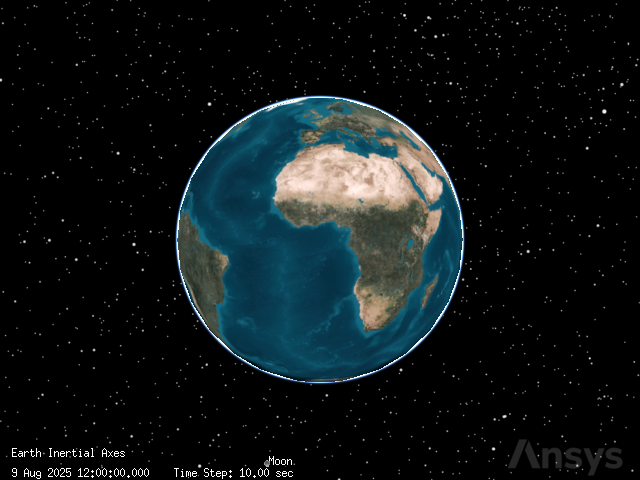

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


plotter = GlobeWidget(root, 640, 480)
plotter.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [4]:
scenario = root.current_scenario
scenario.set_time_period("5 Jun 2022", "6 Jun 2022")
root.rewind()

## Create a facility object

Create a Static STK Object (facility). All new objects are attached to an existing parent object. In this case, the new facility is added to the children collection of the scenario.

In [5]:
from ansys.stk.core.stkobjects import STKObjectType


facility = root.current_scenario.children.new(STKObjectType.FACILITY, "Philadelphia")

**Note:** the “new” method returns an object of the ``ISTKObject`` type.

### Set the facility position

By default, new facility and place objects are created at AGI’s main office location. It is possible to change the facility position.

First set the position units to degrees:

In [6]:
root.units_preferences.item("LatitudeUnit").set_current_unit("deg")
root.units_preferences.item("LongitudeUnit").set_current_unit("deg")

Then, set the position of the facility using a cartodetic (latitude, longitude, altitude) position. The ``position`` property is of the type ``IPosition`` located in the STK Utility library (``ansys.stk.core.stkutil``). Change the position of the facility to latitude $39.95^\circ$ and longitude $-75.16^\circ$, which corresponds approximately to Philadelphia's location:

In [7]:
facility.position.assign_planetodetic(39.95, -75.16, 0)

To get the current position of the facility, run:

In [8]:
latitude, longitude, altitude = facility.position.query_planetodetic_array()
print(f"{latitude = }", f"{longitude = }", f"{altitude = }", sep="\n")

latitude = 39.95
longitude = -75.16
altitude = -0.021741627612921713


### Change the facility label

<!-- Google.WordList.application = off -->
The STK Object Model follows the logic of the STK desktop application. For example, to change the label for the facility, the `IFacility` interface contains the ``graphics`` property, which in turn contains the `label_name` property. To change the label, the “Use Instance Name as Label” property must first be set to ``False``.
<!-- Google.WordList.application = on -->

In [9]:
facility.graphics.use_instance_name_label = False
facility.graphics.label_name = "Philadelphia Facility"

### Add a sensor to a facility

The Sensor object belongs to a group of sub objects. The Sensor object cannot exist by itself. It must be attached to another object, such as a facility or aircraft.

It is possible to use the ``children`` collection of the facility object to check if “MySensor” is already part of the collection. If the sensor already exists, it is possible to get the sensor object from the children collection using the path from the facility to the sensor.

In [10]:
if facility.children.contains(STKObjectType.SENSOR, "MySensor"):
    sensor = root.get_object_from_path("Facility/MyFacility/Sensor/MySensor")

In this case, the sensor has not yet been created, so create the object from the root:

In [11]:
sensor = facility.children.new(STKObjectType.SENSOR, "MySensor")

#### Set the sensor pattern

Now, set the sensor’s pattern to complex conic. The default sensor object is defined as a simple conic sensor. So, the first step is to change the sensor type to complex conic. The API also provides a helper function to set the sensor pattern properties. To access this helper function, get an ``ISensorCommonTasks`` object through the sensor's ``common_tasks`` property.

In [12]:
from ansys.stk.core.stkobjects import SensorPattern


sensor.set_pattern_type(SensorPattern.COMPLEX_CONIC)
sensor.common_tasks.set_pattern_complex_conic(50, 90, 0, 90)

#### Add access constraints to the sensor

The ``access_constraints`` property of the sensor holds an ``AccessConstraintCollection``, which has an ``add_constraint`` method. Use this method to add a range constraint using the ``ACCESS_CONSTRAINTS`` enumeration.

Add an access constraint to the sensor defining a maximum range of $40$ km:

In [13]:
from ansys.stk.core.stkobjects import AccessConstraintType


access_constraint = sensor.access_constraints.add_constraint(AccessConstraintType.RANGE)

This method returns an ``IAccessConstraintMinMax`` object, through it is possible to access the access constraint attributes. Use this object to enable a maximum range value and set it to 40 km (the units are set to km by default):

In [14]:
access_constraint.enable_maximum = True
access_constraint.maximum = 40

### Add a satellite using the SPG4 propagator

**Note:** this portion requires internet access.

First, create the satellite using online data for the International Space Station (SSN number $25544$):

In [15]:
from ansys.stk.core.stkobjects import PropagatorType


satellite = root.current_scenario.children.new(STKObjectType.SATELLITE, "MySatellite")
satellite.set_propagator_type(PropagatorType.SGP4)
propagator = satellite.propagator
propagator.common_tasks.add_segments_from_online_source("25544")
propagator.propagate()

The propagator property of the satellite returns an ``IVehiclePropagatorSGP4`` object, which has a ``common_tasks`` property. Through this property, it is possible to access ``IVehiclePropagatorSGP4CommonTasks``, which holds helper methods for this propagator type. Then, use the ``add_segs_from_online_source`` helper method to add the satellite from the AGI server.

Visualize the satellite's orbit using the 3D graphics window:

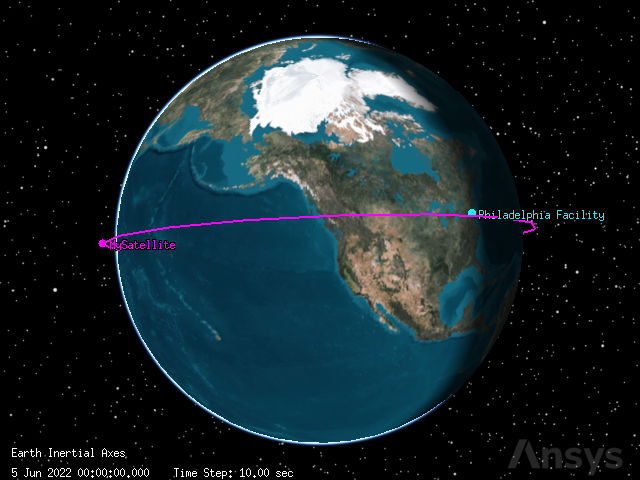

In [16]:
plotter.camera.position = [-9520, 14250, 18300]
plotter.show()

#### Add access constraints to the satellite

Since it is very hard to observe satellites when they are in the Earth's shadow, add a direct sun constraint to the satellite object:

In [17]:
from ansys.stk.core.stkobjects import ConstraintLighting


lighting_constraint = satellite.access_constraints.add_constraint(
    AccessConstraintType.LIGHTING
)
lighting_constraint.condition = ConstraintLighting.DIRECT_SUN

Now that the satellite can only be "seen" if it is illuminated by the Sun, it is possible to run an access or intervisibility calculation.

### Calculate access

Create and calculate the access between facility and satellite:

In [18]:
access = facility.get_access_to_object(satellite)
access.compute_access()

It is possible to access results of STK calculations through data providers. The data providers in the object model are the equivalent of the Report and Graph Manager in the user interface.

### Get AER (azimuth, elevation, range) access results

Determine the access periods using the ``computed_access_interval_times`` property:

In [19]:
access_intervals = access.computed_access_interval_times

Next, get the data provider corresponding to an AER report with the default reference frame.

In [20]:
access_data_provider_aer = access.data_providers.item("AER Data").group.item("Default")
data_provider_elements = ["Time", "Azimuth", "Elevation", "Range"]

Execute the element call return results based on the time interval and time step. The “data sets” represent columns of the report. The order of the columns is the same as in the report. The order of the columns requested in the elements array is ignored.
Since the data is returned in the columns format, create lists that represents the rows of data:

In [21]:
for i in range(0, access_intervals.count):
    times = access_intervals.get_interval(i)
    data_provider_result = access_data_provider_aer.execute_elements(
        times[0], times[1], 1, data_provider_elements
    )
    time_values = data_provider_result.data_sets.get_data_set_by_name(
        "Time"
    ).get_values()
    azimuth_values = data_provider_result.data_sets.get_data_set_by_name(
        "Azimuth"
    ).get_values()
    elevation_values = data_provider_result.data_sets.get_data_set_by_name(
        "Elevation"
    ).get_values()
    range_values = data_provider_result.data_sets.get_data_set_by_name(
        "Range"
    ).get_values()

Alternately, convert all the data provider data sets corresponding to the entire scenario duration to a pandas ``dataframe``:

In [22]:
aer_df = (
    access.data_providers.item("AER Data")
    .group.item("Default")
    .execute(scenario.start_time, scenario.stop_time, 1)
    .data_sets.to_pandas_dataframe()
)
aer_df

,access number,time,azimuth,elevation,range,azimuthrate,elevationrate,rangerate,path delay,from precision pass,to precision pass,from precision path,to precision path,strand name,local hour angle
0,1,5 Jun 2022 00:24:37.599089028,300.052762,0.000244,2358.923995,-0.041374,0.060051,-6.7179,0.007869,0.0,34329.307805,0.0,1.0,Facility/Philadelphia to Satellite/MySatellite,333.73539
1,2,5 Jun 2022 02:03:59.288830876,258.011356,0.000001,2346.569117,-0.169754,0.020131,-2.283346,0.007827,0.0,34330.377019,0.0,1.0,Facility/Philadelphia to Satellite/MySatellite,336.219909
2,3,5 Jun 2022 15:31:07.170631212,184.239352,0.000003,2349.565768,-0.102938,0.051089,-5.655068,0.007837,0.0,34339.069955,0.0,1.0,Facility/Philadelphia to Satellite/MySatellite,358.445653
3,4,5 Jun 2022 17:06:27.701139550,235.590097,0.000066,2355.009054,0.011451,0.062082,-6.887626,0.007855,0.0,34340.096808,0.0,1.0,Facility/Philadelphia to Satellite/MySatellite,341.332402
4,5,5 Jun 2022 18:44:12.639419811,277.398778,0.000008,2362.494324,0.085647,0.054447,-6.051478,0.00788,0.0,34341.149579,0.0,1.0,Facility/Philadelphia to Satellite/MySatellite,333.509388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5251,4,5 Jun 2022 17:17:22.767001058,51.869375,0.000003,2365.638229,0.012308,-0.061728,6.8808,0.007891,0.0,34340.214394,0.0,1.0,Facility/Philadelphia to Satellite/MySatellite,25.17837
5252,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5253,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5254,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


Visualize the data using a line chart:

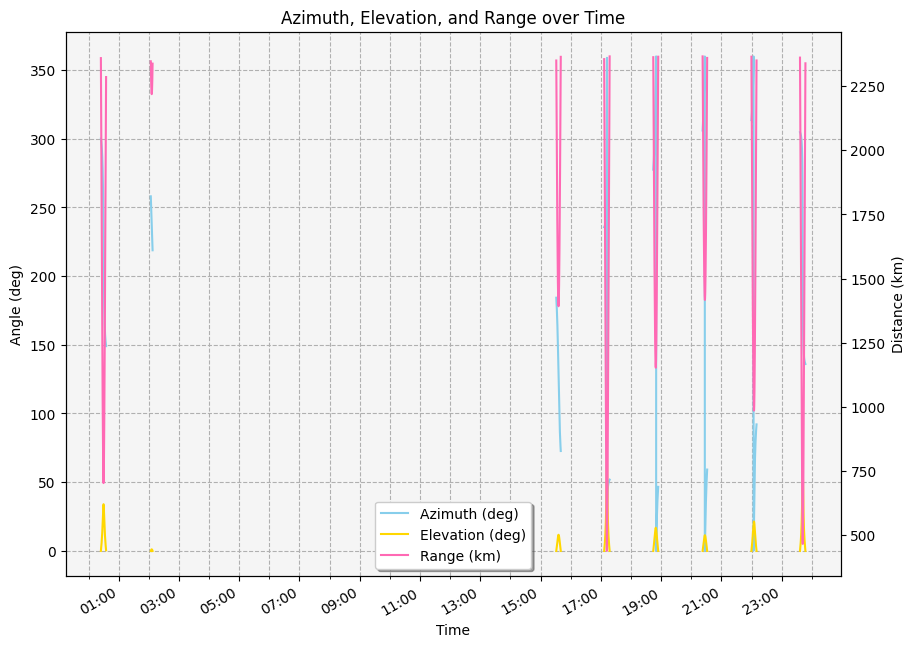

In [23]:
import matplotlib.dates as md
import matplotlib.pyplot as plt
import pandas as pd


# Convert columns to correct types
aer_df["time"] = pd.to_datetime(aer_df["time"])
cols = ["azimuth", "elevation", "range"]
aer_df[cols] = aer_df[cols].apply(pd.to_numeric)

# Create a plot and duplicate the x-axis
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Plot range, azimuth, and elevation, grouped by access interval
aer_df.groupby(by=["access number"]).plot(
    "time", "range", color="hotpink", label="Range (km)", ax=ax2
)
aer_df.groupby(by=["access number"]).plot(
    "time", "azimuth", color="skyblue", label="Azimuth (deg)", ax=ax1
)
aer_df.groupby(by=["access number"]).plot(
    "time", "elevation", color="gold", label="Elevation (deg)", ax=ax1
)

# Set title and axes labels
ax1.set_title("Azimuth, Elevation, and Range over Time")
ax1.set_xlabel("Time")
ax1.set_ylabel("Angle (deg)")
ax2.set_ylabel("Distance (km)")

# Combine legends
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
unique = [(h, l) for i, (h, l) in enumerate(zip(lines, labels)) if l not in labels[:i]]
ax1.legend(*zip(*unique), shadow=True, loc="lower center")
ax2.get_legend().remove()

# Configure style
ax1.set_facecolor("whitesmoke")
ax1.grid(visible=True, which="both", linestyle="--")

# Improve x-axis formatting
formatter = md.DateFormatter("%H:%M")
ax1.xaxis.set_major_formatter(formatter)
# Set major and minor locators
xlocator_major = md.HourLocator(interval=2)
xlocator_minor = md.HourLocator(interval=1)
ax1.xaxis.set_major_locator(xlocator_major)
ax1.xaxis.set_minor_locator(xlocator_minor)
plt.show()

Or, convert the data to a numpy array:

In [24]:
data_provider_result.data_sets.to_numpy_array()[:10]

array([['5 Jun 2022 23:36:17.228000000', '304.6597384798389',
        '7.690884734202653e-05', '2360.8072164694368'],
       ['5 Jun 2022 23:36:18.000000000', '304.64976739063997',
        '0.047668870883251606', '2355.491774173851'],
       ['5 Jun 2022 23:36:19.000000000', '304.63676679432916',
        '0.10947486636925786', '2348.6066136850327'],
       ['5 Jun 2022 23:36:20.000000000', '304.62366979261054',
        '0.17146102149218695', '2341.7216101435324'],
       ['5 Jun 2022 23:36:21.000000000', '304.61047553312335',
        '0.23362894252280153', '2334.836770212341'],
       ['5 Jun 2022 23:36:22.000000000', '304.5971831301829',
        '0.29598022754408626', '2327.9521035815387'],
       ['5 Jun 2022 23:36:23.000000000', '304.5837917104987',
        '0.3585165199533179', '2321.0676170917422'],
       ['5 Jun 2022 23:36:24.000000000', '304.5703003198983',
        '0.42123940150189604', '2314.183326494246'],
       ['5 Jun 2022 23:36:25.000000000', '304.5567080625841',
       

## Analysis Workbench

### Create a vector between the satellite and facility objects

AGI introduced the Vector Geometry Tool (VGT) with STK 9. In STK 10, VGT became part of the Analysis Workbench that also includes the Time Tool and Calculation Tool. To keep the interface clean and to maintain backward compatibility, all Analysis Workbench capability is located in the ``vgt`` property of the ``ISTKObject`` interface.

Create a vector between the satellite and facility objects:

In [25]:
from ansys.stk.core.analysis_workbench import VectorType


vector = facility.analysis_workbench_components.vectors.factory.create(
    "FromTo", "Vector description", VectorType.DISPLACEMENT
)
vector.destination.set_point(
    satellite.analysis_workbench_components.points.item("Center")
)

Visualize the vector and set its size to $4.0$:

In [26]:
from ansys.stk.core.stkobjects import GeometricElementType


boresight_vector = facility.graphics_3d.vector.vector_geometry_tool_components.add(
    GeometricElementType.VECTOR_ELEMENT, "Facility/Philadelphia FromTo Vector"
)
facility.graphics_3d.vector.vector_size_scale = 4.0

**Note:** all vectors on the single object are the same size. To modify the vector’s appearance, it is necessary to set the global vector properties.

**Note:** the add method requires an object type as an enumeration and a fully qualified path to the Analysis Workbench object. The path consists of the path to the parent object, the object name, and the object type (``"Facility/MyFacility FromTo Vector"``).

STK reports times of the local minimum, so get the vector between objects and calculate the vector’s magnitude for each local minimum time:

First, get the built in calculation object from Analysis Workbench:

In [27]:
parameter_sets = access.analysis_workbench_components.parameter_sets.item(
    "From-To-AER(Body)"
)

Then, get the magnitude vector:

In [28]:
magnitude = parameter_sets.embedded_components.item(
    "From-To-AER(Body).Cartesian.Magnitude"
)

Get the times of the minimum value for each access interval:

In [29]:
min_times = parameter_sets.embedded_components.item(
    "From-To-AER(Body).Cartesian.Magnitude.TimesOfLocalMin"
)
time_array = min_times.find_times().times
for at_time in time_array:
    result = magnitude.evaluate(at_time)
    print(f"Result at time {at_time}: {result.value}")

Result at time 5 Jun 2022 00:29:54.346: 703.4346331456488
Result at time 5 Jun 2022 02:05:48.301: 2218.532849415285
Result at time 5 Jun 2022 15:35:34.641: 1392.327361190391
Result at time 5 Jun 2022 17:11:54.368: 439.0647412531941
Result at time 5 Jun 2022 18:49:07.715: 1152.8110323541014
Result at time 5 Jun 2022 20:26:58.466: 1416.9342686962138
Result at time 5 Jun 2022 22:04:43.134: 985.9089992272043
Result at time 5 Jun 2022 23:41:43.194: 466.4188799077625
